In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_PATH = "/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/Original_dataset"

In [3]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        # Attempt to downcast numerical columns
        if pd.api.types.is_integer_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    if verbose: print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
file_map = {
    'calendar': 'calendar.csv',
    'sell_prices': 'sell_prices.csv',
    'sales': 'sales_train_evaluation.csv'
}

loaded_dfs = {}
for df_name, file_name in file_map.items():
    print(f"\nOptimizing {df_name}...")
    loaded_dfs[df_name] = reduce_mem_usage(pd.read_csv(f'{DATA_PATH}/{file_name}'))

calendar = loaded_dfs['calendar']
sell_prices = loaded_dfs['sell_prices']
sales = loaded_dfs['sales']


Optimizing calendar...
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%

Optimizing sell_prices...
Memory usage after optimization is: 143.53 MB
Decreased by 31.2%

Optimizing sales...
Memory usage after optimization is: 95.61 MB
Decreased by 78.9%


### Calendar Processing

In [5]:
print(calendar.head(10).to_markdown())

|    | date       |   wm_yr_wk | weekday   |   wday |   month |   year | d    | event_name_1   | event_type_1   |   event_name_2 |   event_type_2 |   snap_CA |   snap_TX |   snap_WI |
|---:|:-----------|-----------:|:----------|-------:|--------:|-------:|:-----|:---------------|:---------------|---------------:|---------------:|----------:|----------:|----------:|
|  0 | 2011-01-29 |      11101 | Saturday  |      1 |       1 |   2011 | d_1  | nan            | nan            |            nan |            nan |         0 |         0 |         0 |
|  1 | 2011-01-30 |      11101 | Sunday    |      2 |       1 |   2011 | d_2  | nan            | nan            |            nan |            nan |         0 |         0 |         0 |
|  2 | 2011-01-31 |      11101 | Monday    |      3 |       1 |   2011 | d_3  | nan            | nan            |            nan |            nan |         0 |         0 |         0 |
|  3 | 2011-02-01 |      11101 | Tuesday   |      4 |       2 |   2011 | d_4  | 

In [6]:
print(calendar.tail(10).to_markdown())

|      | date       |   wm_yr_wk | weekday   |   wday |   month |   year | d      | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI |
|-----:|:-----------|-----------:|:----------|-------:|--------:|-------:|:-------|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|
| 1959 | 2016-06-10 |      11619 | Friday    |      7 |       6 |   2016 | d_1960 | nan            | nan            | nan            | nan            |         1 |         0 |         0 |
| 1960 | 2016-06-11 |      11620 | Saturday  |      1 |       6 |   2016 | d_1961 | nan            | nan            | nan            | nan            |         0 |         1 |         1 |
| 1961 | 2016-06-12 |      11620 | Sunday    |      2 |       6 |   2016 | d_1962 | nan            | nan            | nan            | nan            |         0 |         1 |         1 |
| 1962 | 2016-06-13 |      11620 | Monday    |      3 |     

In [7]:
event_columns = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

In [8]:
def preprocess_calendar_df(df):
    # Convert 'date' column to datetime objects and set as index
    df['date'] = pd.to_datetime(df['date'])

    # Identify event-related columns
    event_columns = ['event_name_1', 'event_type_1', 'event_name_2',
                     'event_type_2']

    # Fill NaN values in event columns with 'None'
    for col in event_columns:
        if col in df.columns:
            df[col] = df[col].fillna('No Event')

    return df

In [9]:
calendar_processed = preprocess_calendar_df(loaded_dfs['calendar'].copy())

print("Shape of the processed calendar DataFrame:", calendar_processed.shape)
print("\nFirst 5 rows of the processed calendar DataFrame:\n")
print(calendar_processed.head().to_markdown())
print("\nMissing values in event columns after processing:\n")
print(calendar_processed[event_columns].isnull().sum().to_markdown())

Shape of the processed calendar DataFrame: (1969, 14)

First 5 rows of the processed calendar DataFrame:

|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No Event       | No Event       | No Event       | No Event       |         0 |         0 |         0 |
|  1 | 2011-01-30 00:00:00 |      11101 | Sunday    |      2 |       1 |   2011 | d_2 | No Event       | No Event       | No Event       | No Event       |         0 |         0 |         0 |
|  2 | 2011-01-31 00:00:00 |      11101 | Monday    |      3 |       1 |   2011 | d_3 | No Event       | No Event       | No E

### Sell Prices

In [10]:
print(sell_prices.head().to_markdown())

|    | store_id   | item_id       |   wm_yr_wk |   sell_price |
|---:|:-----------|:--------------|-----------:|-------------:|
|  0 | CA_1       | HOBBIES_1_001 |      11325 |         9.58 |
|  1 | CA_1       | HOBBIES_1_001 |      11326 |         9.58 |
|  2 | CA_1       | HOBBIES_1_001 |      11327 |         8.26 |
|  3 | CA_1       | HOBBIES_1_001 |      11328 |         8.26 |
|  4 | CA_1       | HOBBIES_1_001 |      11329 |         8.26 |


In [11]:
print(sell_prices.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float32
dtypes: float32(1), int16(1), object(2)
memory usage: 143.5+ MB
None


In [12]:
print(sell_prices.isnull().sum().to_markdown())

|            |   0 |
|:-----------|----:|
| store_id   |   0 |
| item_id    |   0 |
| wm_yr_wk   |   0 |
| sell_price |   0 |


In [13]:
pd.options.display.float_format = '{:.2f}'.format
print(sell_prices['sell_price'].describe())

count   6841121.00
mean          4.41
std           3.39
min           0.01
25%           2.18
50%           3.47
75%           5.84
max         107.32
Name: sell_price, dtype: float64


### Sales Count

In [14]:
print(sales.head().to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   d_1 |   d_2 |   d_3 |   d_4 |   d_5 |   d_6 |   d_7 |   d_8 |   d_9 |   d_10 |   d_11 |   d_12 |   d_13 |   d_14 |   d_15 |   d_16 |   d_17 |   d_18 |   d_19 |   d_20 |   d_21 |   d_22 |   d_23 |   d_24 |   d_25 |   d_26 |   d_27 |   d_28 |   d_29 |   d_30 |   d_31 |   d_32 |   d_33 |   d_34 |   d_35 |   d_36 |   d_37 |   d_38 |   d_39 |   d_40 |   d_41 |   d_42 |   d_43 |   d_44 |   d_45 |   d_46 |   d_47 |   d_48 |   d_49 |   d_50 |   d_51 |   d_52 |   d_53 |   d_54 |   d_55 |   d_56 |   d_57 |   d_58 |   d_59 |   d_60 |   d_61 |   d_62 |   d_63 |   d_64 |   d_65 |   d_66 |   d_67 |   d_68 |   d_69 |   d_70 |   d_71 |   d_72 |   d_73 |   d_74 |   d_75 |   d_76 |   d_77 |   d_78 |   d_79 |   d_80 |   d_81 |   d_82 |   d_83 |   d_84 |   d_85 |   d_86 |   d_87 |   d_88 |   d_89 |   d_90 |   d_91 |   d_92 |   d_93 |   d_94 |   d_95 |   d_96 |   d_97 |   d_98 |   d_99 |   d_100 |   d_

In [15]:
print(sales.isna().sum().sum())

0


In [16]:
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Identify value_vars (all columns starting with 'd_')
sales_cols = [col for col in sales.columns if 'd_' in col]

# Perform melt operation
sales_melted = sales.melt(
    id_vars=id_cols,
    var_name='d',
    value_name='sales_count'
    )

In [17]:
print("Shape of the melted sales DataFrame:", sales_melted.shape)
print(sales_melted.head().to_markdown())

Shape of the melted sales DataFrame: (59181090, 8)
|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   | d   |   sales_count |
|---:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|:----|--------------:|
|  0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |             0 |
|  1 | HOBBIES_1_002_CA_1_evaluation | HOBBIES_1_002 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |             0 |
|  2 | HOBBIES_1_003_CA_1_evaluation | HOBBIES_1_003 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |             0 |
|  3 | HOBBIES_1_004_CA_1_evaluation | HOBBIES_1_004 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |             0 |
|  4 | HOBBIES_1_005_CA_1_evaluation | HOBBIES_1_005 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |             0 |


In [18]:
print(sales_melted.tail().to_markdown())
del sales
gc.collect()

|          | id                          | item_id     | dept_id   | cat_id   | store_id   | state_id   | d      |   sales_count |
|---------:|:----------------------------|:------------|:----------|:---------|:-----------|:-----------|:-------|--------------:|
| 59181085 | FOODS_3_823_WI_3_evaluation | FOODS_3_823 | FOODS_3   | FOODS    | WI_3       | WI         | d_1941 |             1 |
| 59181086 | FOODS_3_824_WI_3_evaluation | FOODS_3_824 | FOODS_3   | FOODS    | WI_3       | WI         | d_1941 |             0 |
| 59181087 | FOODS_3_825_WI_3_evaluation | FOODS_3_825 | FOODS_3   | FOODS    | WI_3       | WI         | d_1941 |             2 |
| 59181088 | FOODS_3_826_WI_3_evaluation | FOODS_3_826 | FOODS_3   | FOODS    | WI_3       | WI         | d_1941 |             0 |
| 59181089 | FOODS_3_827_WI_3_evaluation | FOODS_3_827 | FOODS_3   | FOODS    | WI_3       | WI         | d_1941 |             1 |


0

In [19]:
sales_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           object
 1   item_id      object
 2   dept_id      object
 3   cat_id       object
 4   store_id     object
 5   state_id     object
 6   d            object
 7   sales_count  int16 
dtypes: int16(1), object(7)
memory usage: 3.2+ GB


In [20]:
print(sales_melted['sales_count'].describe())

count   59181090.00
mean           1.13
std            3.87
min            0.00
25%            0.00
50%            0.00
75%            1.00
max          763.00
Name: sales_count, dtype: float64


In [21]:
# Merge calendar_processed with sales_melted on the 'd' column, keeping calendar on the left
sales_calendar_merged = pd.merge(calendar_processed, sales_melted, on='d', how='left')

print("Shape of the merged DataFrame:", sales_calendar_merged.shape)

Shape of the merged DataFrame: (59181118, 21)


In [22]:
print(sales_calendar_merged.isnull().sum().to_markdown())

|              |   0 |
|:-------------|----:|
| date         |   0 |
| wm_yr_wk     |   0 |
| weekday      |   0 |
| wday         |   0 |
| month        |   0 |
| year         |   0 |
| d            |   0 |
| event_name_1 |   0 |
| event_type_1 |   0 |
| event_name_2 |   0 |
| event_type_2 |   0 |
| snap_CA      |   0 |
| snap_TX      |   0 |
| snap_WI      |   0 |
| id           |  28 |
| item_id      |  28 |
| dept_id      |  28 |
| cat_id       |  28 |
| store_id     |  28 |
| state_id     |  28 |
| sales_count  |  28 |


In [23]:
print(sales_calendar_merged.tail(40).to_markdown())

|          | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d      | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI | id                          | item_id     | dept_id   | cat_id   | store_id   | state_id   |   sales_count |
|---------:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:-------|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|:----------------------------|:------------|:----------|:---------|:-----------|:-----------|--------------:|
| 59181078 | 2016-05-22 00:00:00 |      11617 | Sunday    |      2 |       5 |   2016 | d_1941 | No Event       | No Event       | No Event       | No Event       |         0 |         0 |         0 | FOODS_3_816_WI_3_evaluation | FOODS_3_816 | FOODS_3   | FOODS    | WI_3       | WI         |             0 |
| 59181079 | 2016-05-22 00:00:00 |      11617 | Sunday    |      2 |  

Calendar had more dates at the end (d) for which no corresponding sales value exists. We need to delete these entries.

In [24]:
sales_calendar_merged.dropna(subset=['id'], inplace=True)
print("Shape of the DataFrame after dropping NaNs in 'id' and 'sales_count':", sales_calendar_merged.shape)
print("\nMissing values in 'id' and 'sales_count' after dropping NaNs:\n")
print(sales_calendar_merged[['id', 'sales_count']].isnull().sum().to_markdown())

Shape of the DataFrame after dropping NaNs in 'id' and 'sales_count': (59181090, 21)

Missing values in 'id' and 'sales_count' after dropping NaNs:

|             |   0 |
|:------------|----:|
| id          |   0 |
| sales_count |   0 |


In [25]:
del calendar_processed, sales_melted
gc.collect()

0

### Merge all the data frames to get the final dataset

In [26]:
final_merged = pd.merge(
    sales_calendar_merged,
    sell_prices,
    on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left'
)

In [27]:
del sales_calendar_merged, sell_prices
gc.collect()

0

In [28]:
final_merged.shape

(59181090, 22)

In [29]:
print(final_merged.head().to_markdown())

|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   sales_count |   sell_price |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|--------------:|-------------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No Event       | No Event       | No Event       | No Event       |         0 |         0 |         0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         |             0 |          nan |
|  1 | 2011-01-29 00:00:00 |      11101 

In [30]:
final_merged['item_id'].nunique()

3049

In [31]:
final_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   wm_yr_wk      int16         
 2   weekday       object        
 3   wday          int8          
 4   month         int8          
 5   year          int16         
 6   d             object        
 7   event_name_1  object        
 8   event_type_1  object        
 9   event_name_2  object        
 10  event_type_2  object        
 11  snap_CA       int8          
 12  snap_TX       int8          
 13  snap_WI       int8          
 14  id            object        
 15  item_id       object        
 16  dept_id       object        
 17  cat_id        object        
 18  store_id      object        
 19  state_id      object        
 20  sales_count   float64       
 21  sell_price    float32       
dtypes: datetime64[ns](1), float32(1), float64(1), int16(2), int8(5),

In [32]:
for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', \
            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
    final_merged[col] = final_merged[col].astype('category')

In [33]:
final_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   wm_yr_wk      int16         
 2   weekday       object        
 3   wday          int8          
 4   month         int8          
 5   year          int16         
 6   d             object        
 7   event_name_1  category      
 8   event_type_1  category      
 9   event_name_2  category      
 10  event_type_2  category      
 11  snap_CA       int8          
 12  snap_TX       int8          
 13  snap_WI       int8          
 14  id            object        
 15  item_id       category      
 16  dept_id       category      
 17  cat_id        category      
 18  store_id      category      
 19  state_id      category      
 20  sales_count   float64       
 21  sell_price    float32       
dtypes: category(9), datetime64[ns](1), float32(1), float64(1), int16

In [34]:
print(final_merged.isna().sum())

date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
d                      0
event_name_1           0
event_type_1           0
event_name_2           0
event_type_2           0
snap_CA                0
snap_TX                0
snap_WI                0
id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
sales_count            0
sell_price      12299413
dtype: int64


### Handling Missing Values

When a store sets a price for an item, that price is usually valid for the entire week (or until it's changed). The `NaN` values appear in the merged daily dataset on days where the price wasn't explicitly listed (maybe because it was discontinued or it was not in the inventory) but the previous price should still be in effect.

For the the ~12 million missing `sell_price` values that exist we would group by each individual product by id and then forward-fill (ffill) the prices, followed by a back-fill (bfill) to catch any `NaNs` at the beginning of a product's life.

In [35]:
final_merged['sell_price'] = final_merged.groupby('id')['sell_price'].ffill()

In [36]:
final_merged['sell_price'] = final_merged.groupby('id')['sell_price'].bfill()

In [37]:
SAVE_PATH = '/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/Saved Data'
#final_merged.to_csv(f'{SAVE_PATH}/final_merged_data.csv', index=False)
df = final_merged
del final_merged
gc.collect()

0

# **EDA**

## Total Sales Over Time

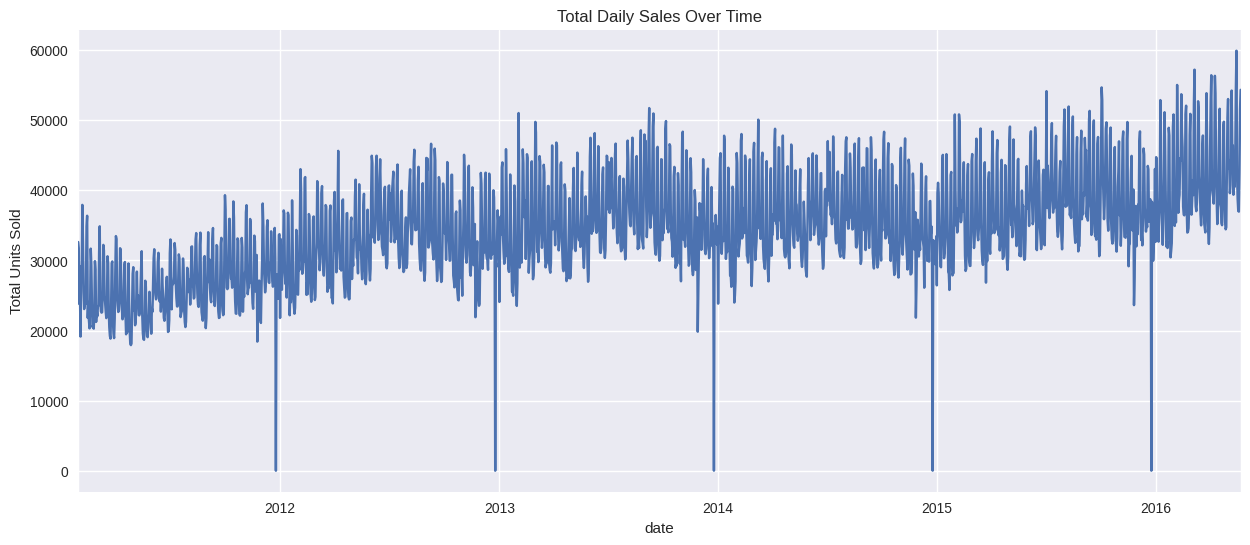

In [38]:
daily_sales = df.groupby('date')['sales_count'].sum()
plt.figure(figsize=(15, 6))
daily_sales.plot(title='Total Daily Sales Over Time')
plt.ylabel('Total Units Sold')
plt.show()
del daily_sales

## Sales by Year and Month (Seasonality)

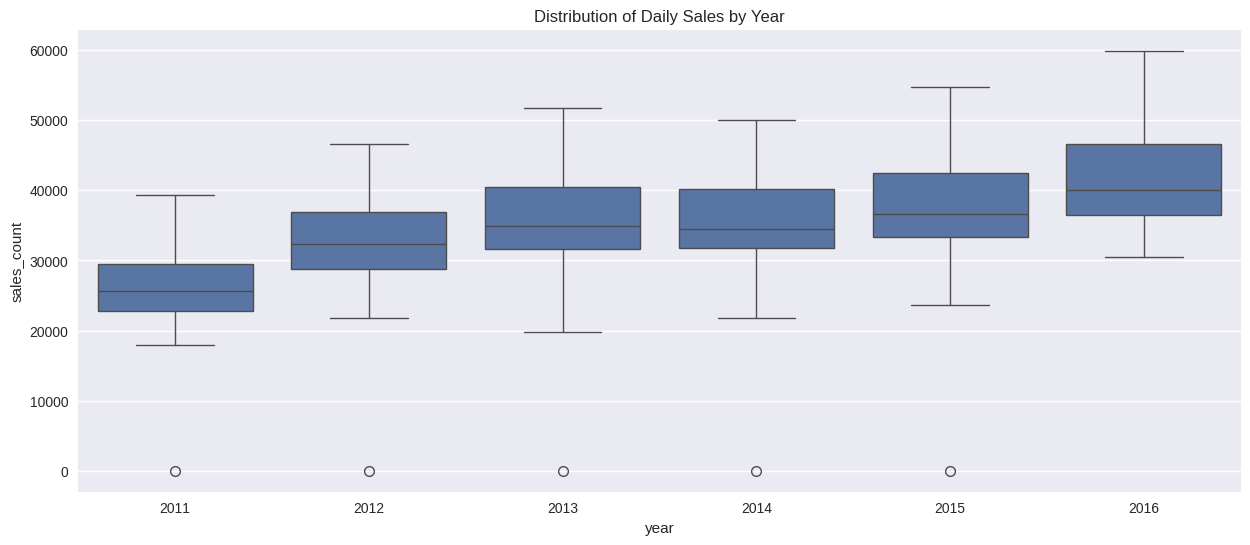

In [39]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='year', y='sales_count', data=df.groupby(['year', 'date']).sales_count.sum().reset_index())
plt.title('Distribution of Daily Sales by Year')
plt.show()

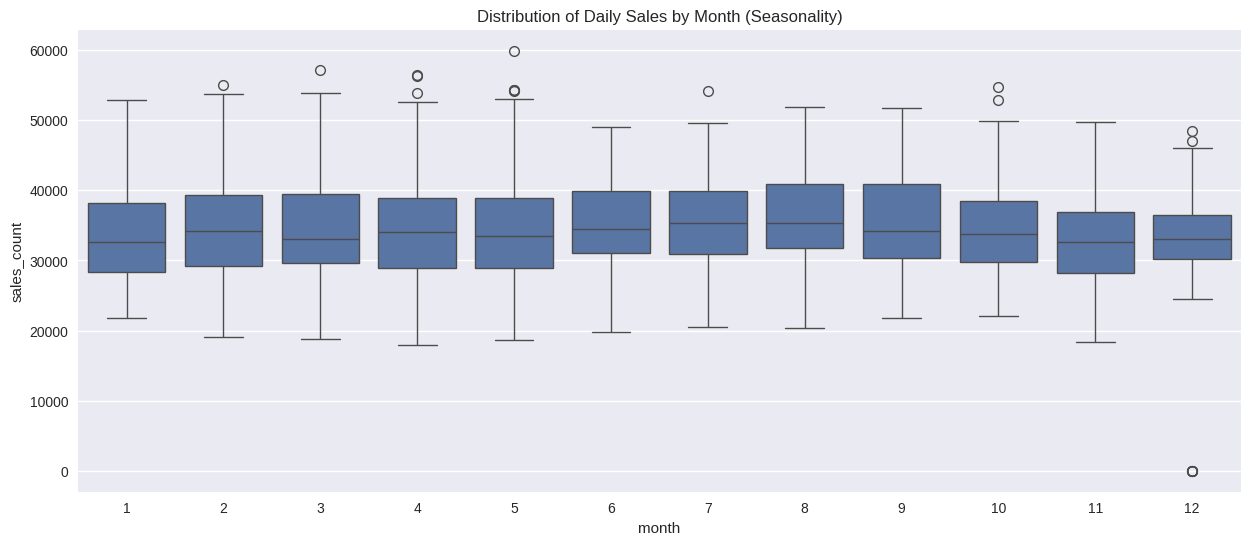

In [40]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='month', y='sales_count', data=df.groupby(['month', 'date']).sales_count.sum().reset_index())
plt.title('Distribution of Daily Sales by Month (Seasonality)')
plt.show()

## Sales by State

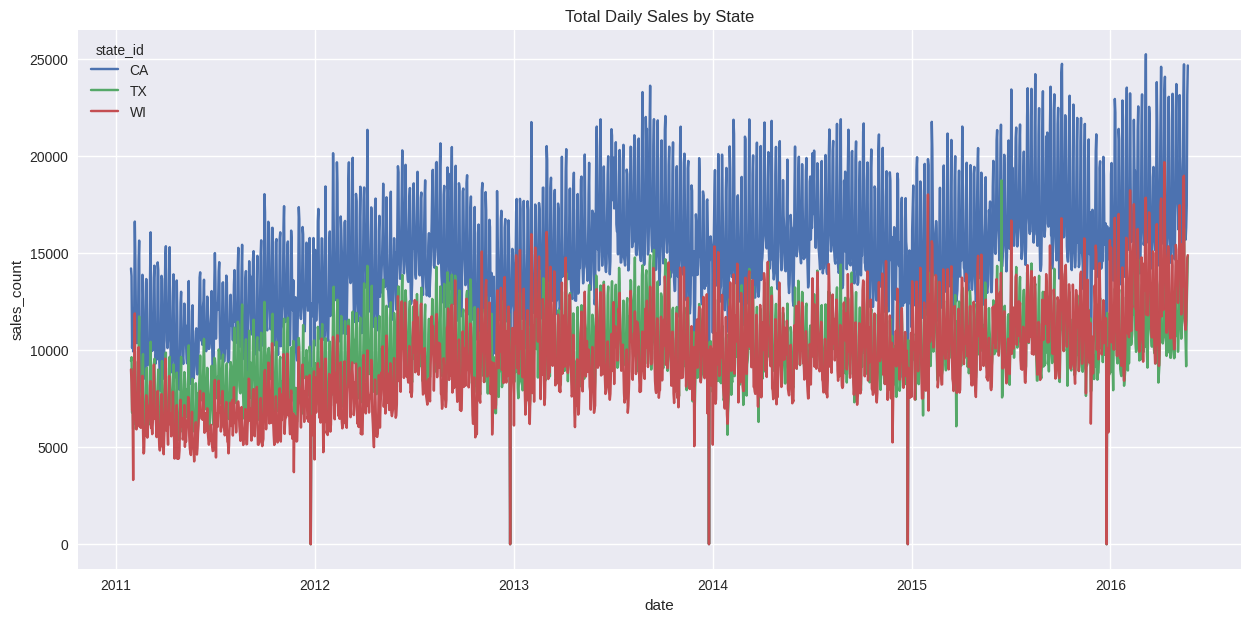

In [41]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df, x='date', y='sales_count', hue='state_id', estimator='sum', errorbar=None)
plt.title('Total Daily Sales by State')
plt.show()

## Sales by Product Category

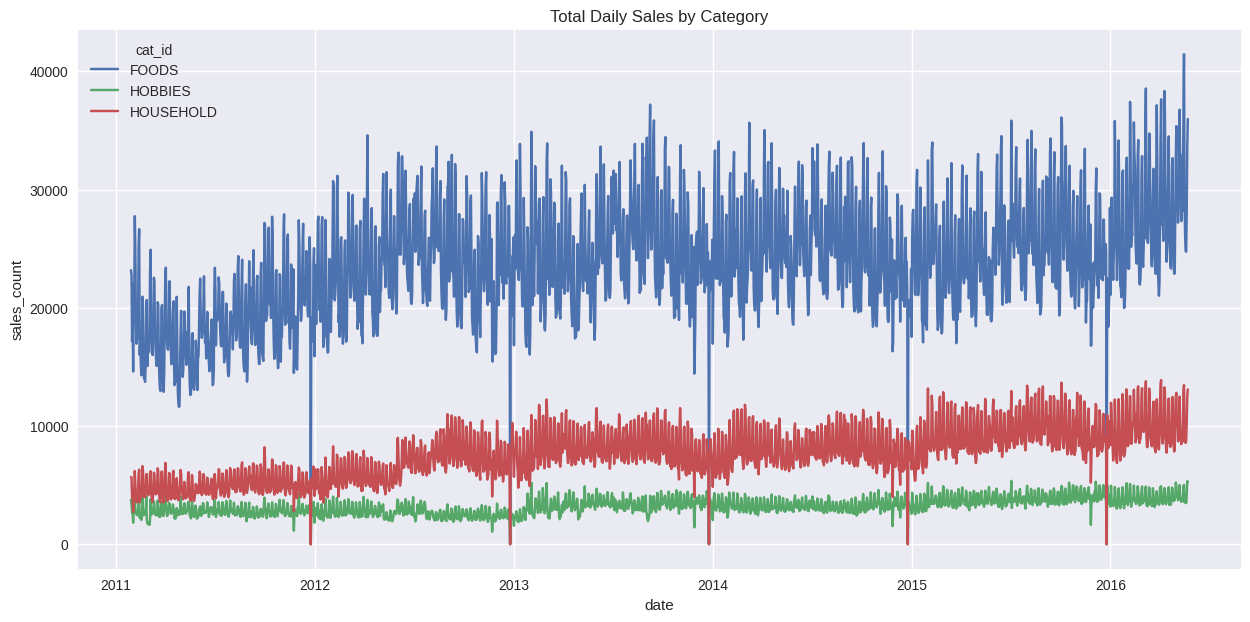

In [42]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df, x='date', y='sales_count', hue='cat_id', estimator='sum', errorbar=None)
plt.title('Total Daily Sales by Category')
plt.show()

## Sales by Store

/tmp/ipython-input-1101696820.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_store_sales = df.groupby(['store_id', 'date'])['sales_count'].sum().reset_index()


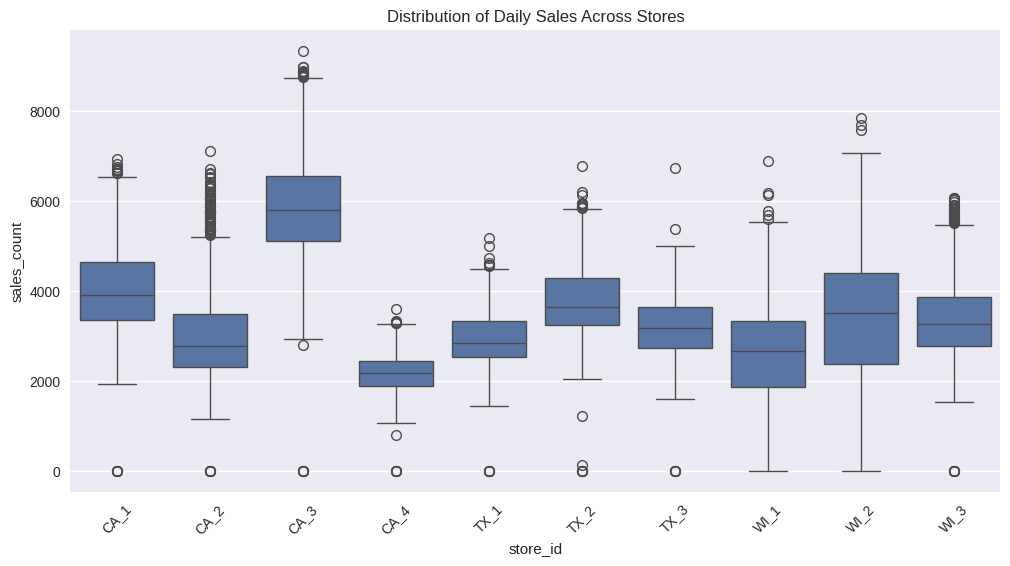

320

In [43]:
daily_store_sales = df.groupby(['store_id', 'date'])['sales_count'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(x='store_id', y='sales_count', data=daily_store_sales)
plt.title('Distribution of Daily Sales Across Stores')
plt.xticks(rotation=45)
plt.show()
del daily_store_sales
gc.collect()

## Price Distribution

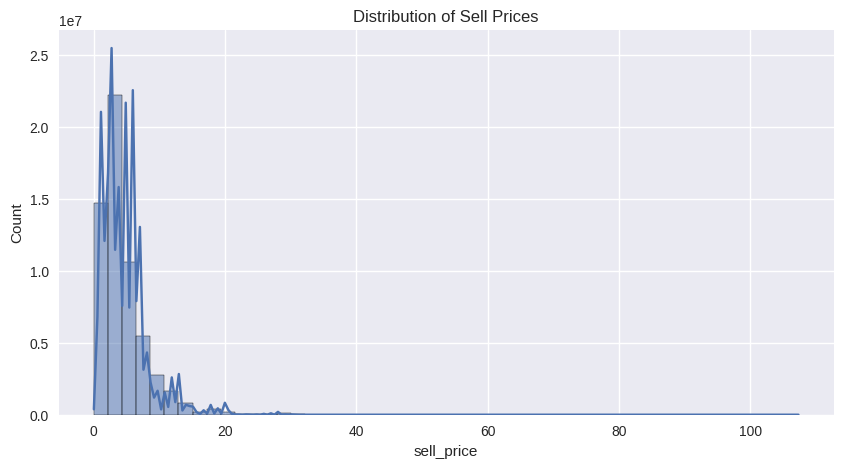

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(df['sell_price'], bins=50, kde=True)
plt.title('Distribution of Sell Prices')
plt.show()

Running plots on a 59-million-row DataFrame seems to be very slow or impossible. We will use random samples from 10% of the dataframe.

In [69]:
df_sample = df.sample(frac=0.2, random_state=42)

26392

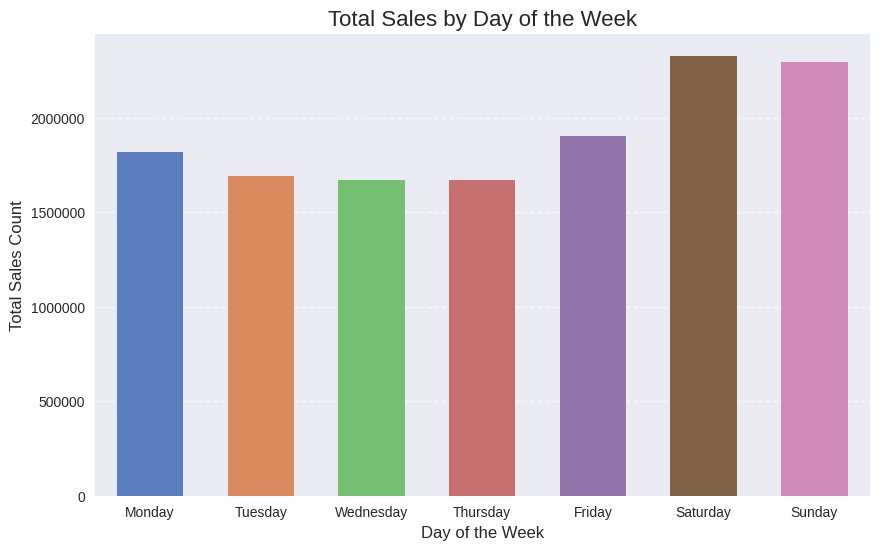

In [70]:
sales_by_weekday = df_sample.groupby('weekday')['sales_count'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='weekday',
    y='sales_count',
    data=sales_by_weekday,
    palette='muted',
    hue='weekday',
    dodge=False,
    width=0.6)


plt.ticklabel_format(style='plain', axis='y')

plt.title('Total Sales by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Sales Count', fontsize=12)


plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

del sales_by_weekday
gc.collect()

/tmp/ipython-input-2324881495.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_sales = event_sales.groupby('event_name_1')['sales_count'].sum().reset_index()
/tmp/ipython-input-2324881495.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


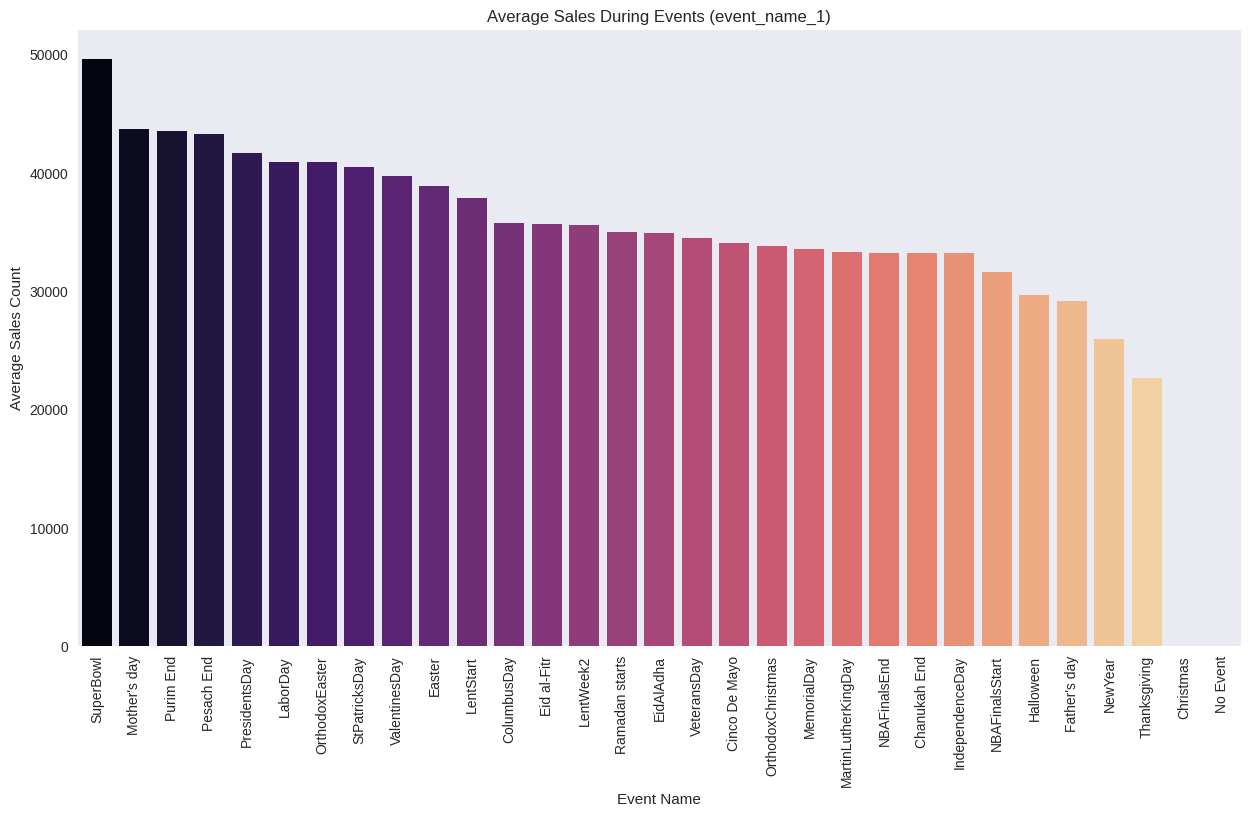

2658

In [71]:
event_sales= df_sample[df_sample['event_name_1'] != 'No Event']
event_sales = event_sales.groupby('event_name_1')['sales_count'].sum().reset_index()
event_sales = event_sales.sort_values(by='sales_count', ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(
    x='event_name_1',
    y='sales_count',
    data=event_sales,
    palette='magma',
    order=event_sales['event_name_1']  # This line tells seaborn the order
)
plt.title('Average Sales During Events (event_name_1)')
plt.xlabel('Event Name')
plt.ylabel('Average Sales Count')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


del event_sales
gc.collect()

In [72]:
!pip install calmap

In [73]:
daily_avg_sales = df.groupby(['date', 'cat_id'])['sales_count'].mean().reset_index()
daily_avg_sales.set_index('date', inplace=True)

/tmp/ipython-input-509323949.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_avg_sales = df.groupby(['date', 'cat_id'])['sales_count'].mean().reset_index()


In [74]:
import calmap
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
years = [2012, 2013, 2014, 2015] # Years to plot

/tmp/ipython-input-1980320997.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_avg_sales = df.groupby(['date', 'cat_id'])['sales_count'].mean().reset_index()


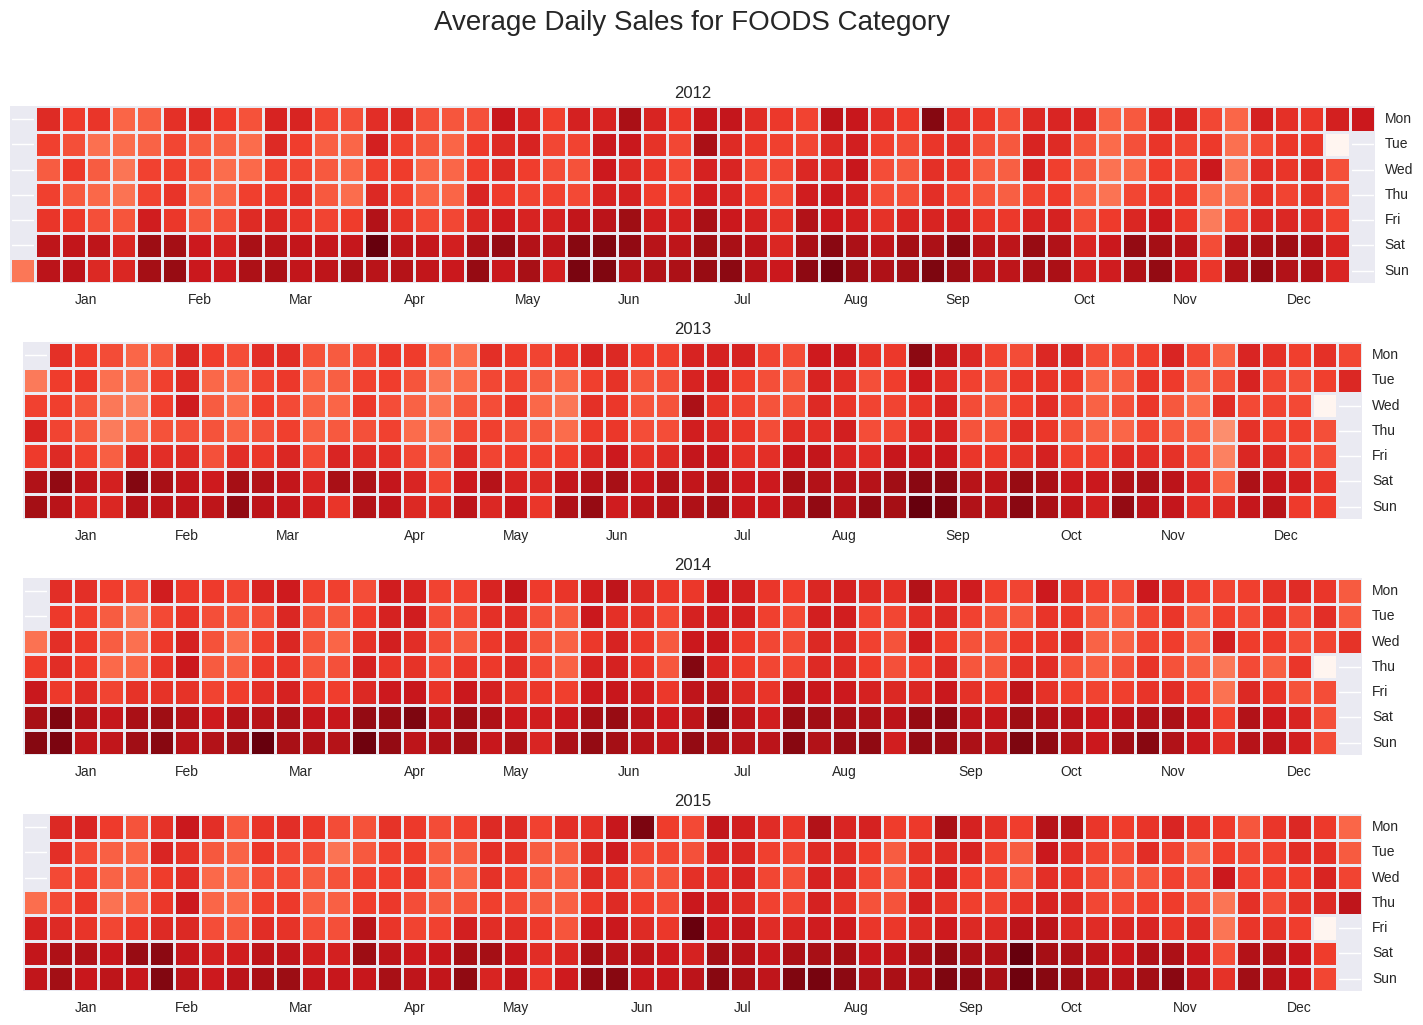

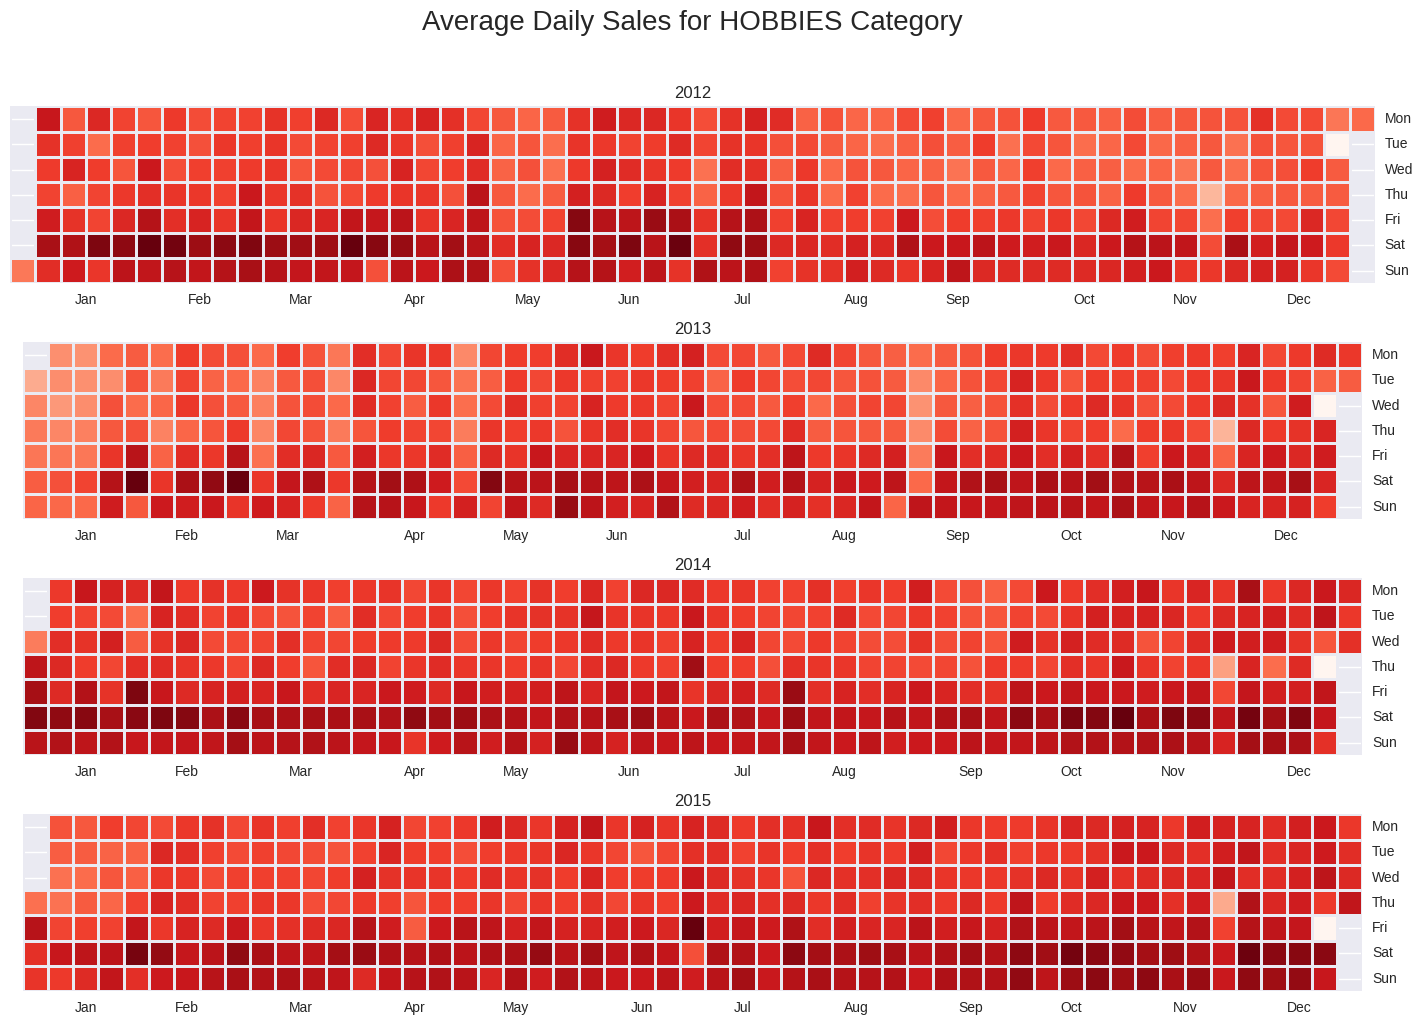

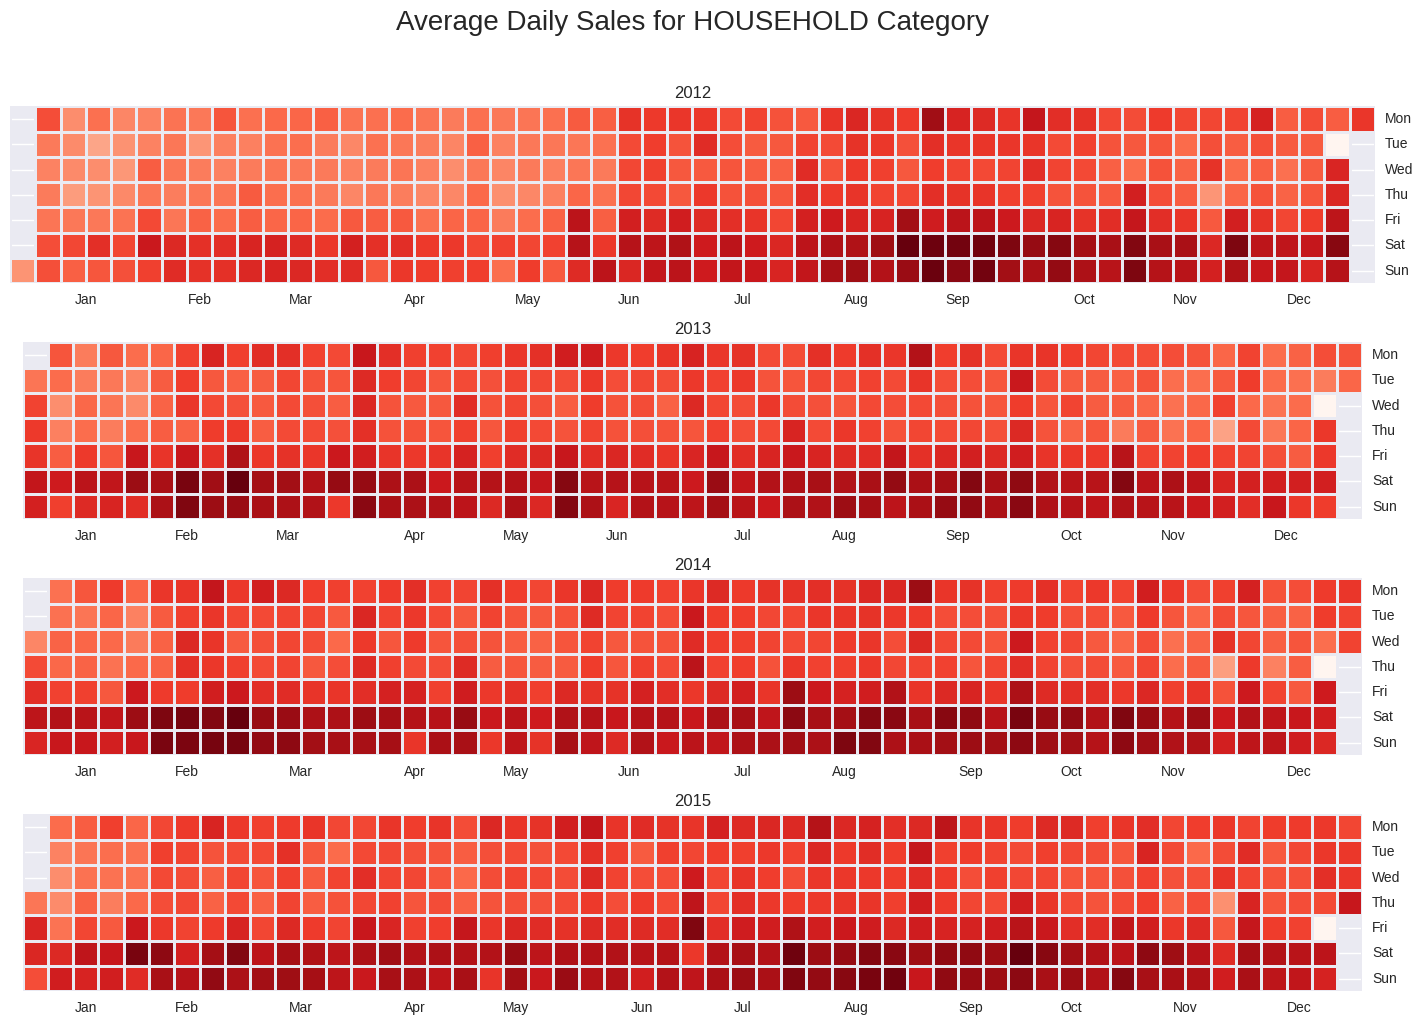

40559

In [76]:
daily_avg_sales = df.groupby(['date', 'cat_id'])['sales_count'].mean().reset_index()
daily_avg_sales.set_index('date', inplace=True)

# Loop through each category to create plots
for category in daily_avg_sales['cat_id'].unique():
    fig, axes = plt.subplots(len(years), 1, figsize=(20, 10))
    fig.suptitle(f'Average Daily Sales for {category} Category', fontsize=20, y=1.02)

    category_sales = daily_avg_sales[daily_avg_sales['cat_id'] == category]['sales_count']

    for i, year in enumerate(years):
        sales_year = category_sales[str(year)]

        if not sales_year.empty:
            # Scale the values for the current year
            vals_scaled = sscale.fit_transform(sales_year.values.reshape(-1, 1))

            scaled_series = pd.Series(vals_scaled.flatten(), index=sales_year.index)

            # Plot the calendar heatmap
            ax = axes[i]
            calmap.yearplot(scaled_series, year=year, ax=ax)
            ax.set_title(str(year))

    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to prevent title overlap
    plt.show()

# Clean up memory
del daily_avg_sales
gc.collect()

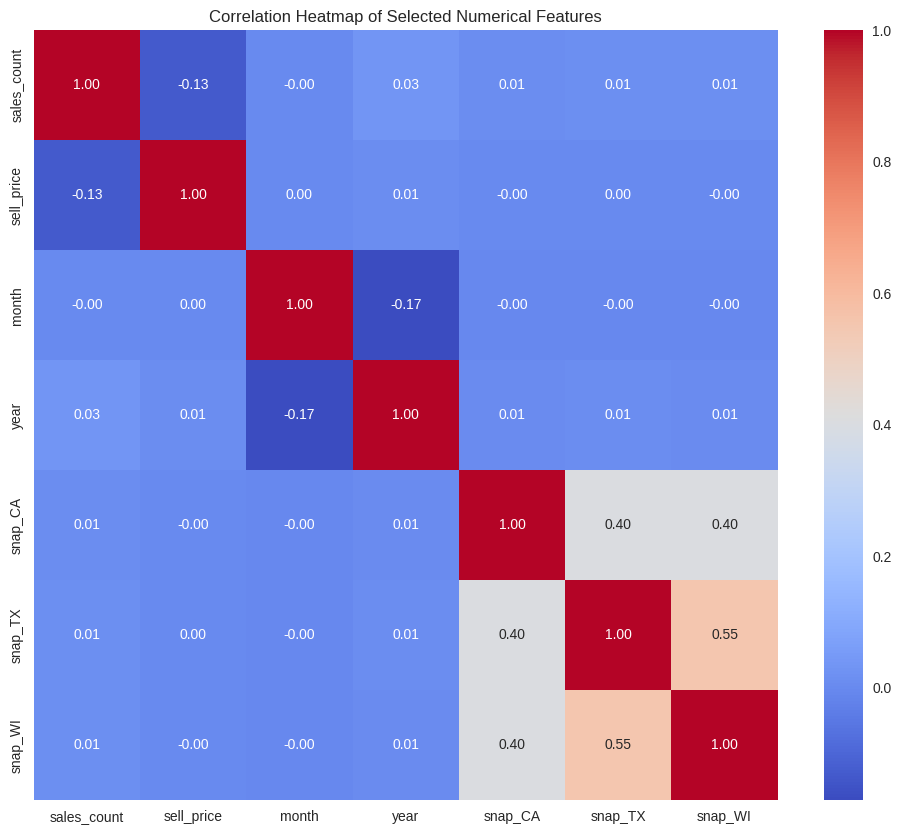

In [77]:
selected_numerical_cols = ['sales_count', 'sell_price', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']

correlation_matrix = df_sample[selected_numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected Numerical Features')
plt.show()

# Feature Engineering

In [78]:
print(df.head().to_markdown())

|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   sales_count |   sell_price |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|--------------:|-------------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No Event       | No Event       | No Event       | No Event       |         0 |         0 |         0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         |             0 |         9.58 |
|  1 | 2011-01-29 00:00:00 |      11101 

In [79]:
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week.astype("int8")
df['is_weekend'] = (df['day_of_week'] >= 5).astype("int8")

Lag features would provide short-term history directly to the model.

In [80]:
lags = [28, 30, 120, 365]
for lag in lags:
    df[f'sales_lag_{lag}'] = df.groupby('id')['sales_count'].transform(
        lambda x: x.shift(lag)
    )

In [81]:
print(df.head().to_markdown())

|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   sales_count |   sell_price |   day_of_week |   week_of_year |   is_weekend |   sales_lag_28 |   sales_lag_30 |   sales_lag_120 |   sales_lag_365 |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|--------------:|-------------:|--------------:|---------------:|-------------:|---------------:|---------------:|----------------:|----------------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No Event       | No Event       | No

In [82]:
# Price change from the previous week
df['price_change'] = df.groupby('id')['sell_price'].transform(lambda x: x.diff())

# Price relative to its average for that month
df['price_vs_month_avg'] = df['sell_price'] / df.groupby(['id', 'year', 'month'])['sell_price'].transform('mean')

In [83]:
print(df.head().to_markdown())

|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   sales_count |   sell_price |   day_of_week |   week_of_year |   is_weekend |   sales_lag_28 |   sales_lag_30 |   sales_lag_120 |   sales_lag_365 |   price_change |   price_vs_month_avg |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|--------------:|-------------:|--------------:|---------------:|-------------:|---------------:|---------------:|----------------:|----------------:|---------------:|---------------------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Sa

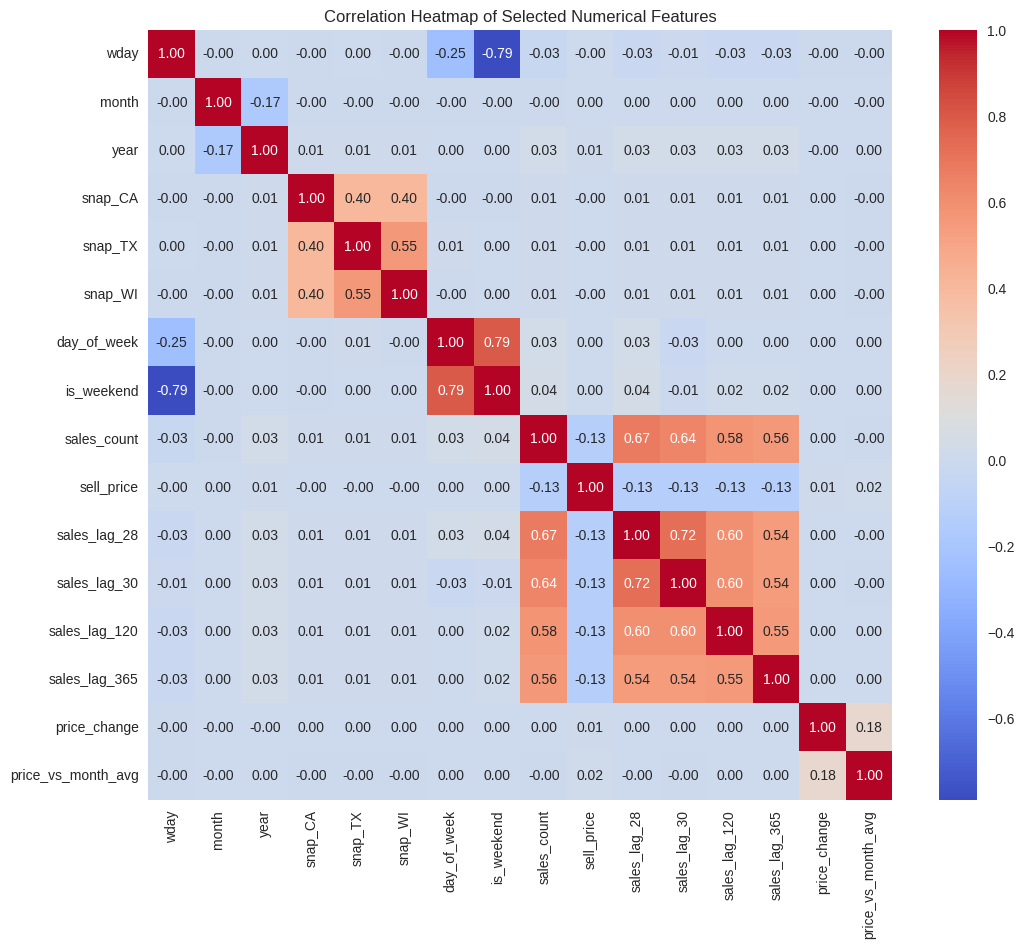

In [86]:
selected_numerical_cols = ['wday', 'month', 'year', \
                           'snap_CA', 'snap_TX', 'snap_WI', 'day_of_week', \
                           'is_weekend', 'sales_count', 'sell_price', 'sales_lag_28', 'sales_lag_30', \
                           'sales_lag_120', 'sales_lag_365', 'price_change', 'price_vs_month_avg']

correlation_matrix = df[selected_numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected Numerical Features')
plt.show()

In [87]:
print(df.isna().sum().to_markdown())

|                    |                0 |
|:-------------------|-----------------:|
| date               |      0           |
| wm_yr_wk           |      0           |
| weekday            |      0           |
| wday               |      0           |
| month              |      0           |
| year               |      0           |
| d                  |      0           |
| event_name_1       |      0           |
| event_type_1       |      0           |
| event_name_2       |      0           |
| event_type_2       |      0           |
| snap_CA            |      0           |
| snap_TX            |      0           |
| snap_WI            |      0           |
| id                 |      0           |
| item_id            |      0           |
| dept_id            |      0           |
| cat_id             |      0           |
| store_id           |      0           |
| state_id           |      0           |
| sales_count        |      0           |
| sell_price         |      0     

These new missing values in the new features exist because for the new feautures the prior data is as expected does not exist

In [89]:
cols_to_fill = [col for col in df.columns if 'lag' in col or 'roll' in col or 'change' in col]

In [90]:
df[cols_to_fill] = df[cols_to_fill].fillna(0)

In [92]:
print(df.isnull().sum())

date                  0
wm_yr_wk              0
weekday               0
wday                  0
month                 0
year                  0
d                     0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
sales_count           0
sell_price            0
day_of_week           0
week_of_year          0
is_weekend            0
sales_lag_28          0
sales_lag_30          0
sales_lag_120         0
sales_lag_365         0
price_change          0
price_vs_month_avg    0
dtype: int64


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 31 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   wm_yr_wk            int16         
 2   weekday             object        
 3   wday                int8          
 4   month               int8          
 5   year                int16         
 6   d                   object        
 7   event_name_1        category      
 8   event_type_1        category      
 9   event_name_2        category      
 10  event_type_2        category      
 11  snap_CA             int8          
 12  snap_TX             int8          
 13  snap_WI             int8          
 14  id                  object        
 15  item_id             category      
 16  dept_id             category      
 17  cat_id              category      
 18  store_id            category      
 19  state_id            category      
 20  

In [94]:
gc.collect()

43494

In [96]:
print(df.describe().to_markdown())

|       | date                          |        wm_yr_wk |        wday |        month |           year |     snap_CA |     snap_TX |     snap_WI |   sales_count |    sell_price |   day_of_week |   week_of_year |   is_weekend |   sales_lag_28 |   sales_lag_30 |   sales_lag_120 |   sales_lag_365 |   price_change |   price_vs_month_avg |
|:------|:------------------------------|----------------:|------------:|-------------:|---------------:|------------:|------------:|------------:|--------------:|--------------:|--------------:|---------------:|-------------:|---------------:|---------------:|----------------:|----------------:|---------------:|---------------------:|
| count | 59181090                      |     5.91811e+07 | 5.91811e+07 |  5.91811e+07 |    5.91811e+07 | 5.91811e+07 | 5.91811e+07 | 5.91811e+07 |   5.91811e+07 |   5.91811e+07 |   5.91811e+07 |    5.91811e+07 |  5.91811e+07 |    5.91811e+07 |    5.91811e+07 |     5.91811e+07 |     5.91811e+07 |    5.91811e+07 |          

In [97]:
df_reduced = reduce_mem_usage(df)

Memory usage after optimization is: 4853.88 MB
Decreased by 21.1%


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 31 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   wm_yr_wk            int16         
 2   weekday             object        
 3   wday                int8          
 4   month               int8          
 5   year                int16         
 6   d                   object        
 7   event_name_1        category      
 8   event_type_1        category      
 9   event_name_2        category      
 10  event_type_2        category      
 11  snap_CA             int8          
 12  snap_TX             int8          
 13  snap_WI             int8          
 14  id                  object        
 15  item_id             category      
 16  dept_id             category      
 17  cat_id              category      
 18  store_id            category      
 19  state_id            category      
 20  

In [100]:
df['sales_count'] = df['sales_count'].astype('int16')
df_reduced = reduce_mem_usage(df)

Memory usage after optimization is: 4741.01 MB
Decreased by 0.0%


In [101]:
def reduce_mem_usage2(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Convert remaining object columns to category
for col in ['id', 'weekday', 'd']:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# Now, apply the optimization to your DataFrame
df_reduced = reduce_mem_usage2(df)

Memory usage decreased to 3669.97 Mb (0.0% reduction)


In [102]:
OUTPUT_PATH = '/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/Saved Data/processed_data.parquet'

df_reduced.to_parquet(OUTPUT_PATH, index=False)